In [11]:
# Import libraries
from sklearn.model_selection import train_test_split
import cv2
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.applications import InceptionV3, ResNet50V2, NASNetLarge
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
# from lime import lime_image
from skimage.segmentation import mark_boundaries, slic
from tensorflow.keras.models import load_model

['Cyst', 'Normal', 'Stone', 'Tumor']
Total images processed: 12446
Total Cyst images processed: 3709.0
Total Normal images processed: 5077.0
Total Stone images processed: 1377.0
Total Tumor images processed: 2283.0


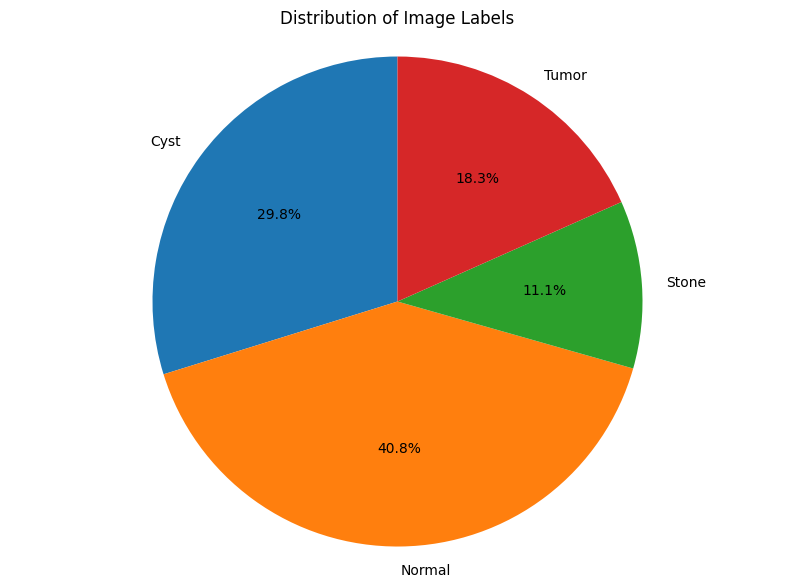

In [2]:
data_path = r"D:\LIME-Project\xai1\Kidney Dataset\Kidney Dataset\CT-KIDNEY-DATASET"
img_size = (224, 224)

# Load and preprocess images
def preprocess_images(data_path, img_size):
    images = []
    labels = []
    print(os.listdir(data_path))
    count = np.zeros(len([not os.path.isdir(i) for i in os.listdir(data_path)]))
    for label in os.listdir(data_path):
        label_path = os.path.join(data_path, label)
        if not os.path.isdir(label_path):
            continue
        
        for img_file in os.listdir(label_path):
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            
            if img is not None:
                img_resized = cv2.resize(img, img_size)
                img_normalized = img_resized / 255.0
                images.append(img_normalized)
                
                # One-hot encoding for labels
                if label == 'Cyst':
                    labels.append([0, 0, 0, 0])  # Cyst -> [0, 0]
                    count[0]+=1
                if label == 'Normal':
                    labels.append([0, 1, 0, 0])  # Normal -> [0, 1]
                    count[1]+=1
                if label == 'Stone':
                    labels.append([0, 0, 1, 0])  # Stone -> [1, 0]
                    count[2]+=1
                if label == 'Tumor':
                    labels.append([0, 0, 0, 1])  # Tumor -> [1, 1]
                    count[3]+=1

    images = np.array(images).reshape(-1, img_size[0], img_size[1], 1)  # Reshape for CNN input
    labels = np.array(labels)  # Convert labels to numpy array
    
    print(f"Total images processed: {len(images)}")
    print(f"Total Cyst images processed: {count[0]}")
    print(f"Total Normal images processed: {count[1]}")
    print(f"Total Stone images processed: {count[2]}")
    print(f"Total Tumor images processed: {count[3]}")

    # Create a pie chart
    plt.figure(figsize=(10, 7))
    plt.pie(count[:4], labels=["Cyst", "Normal", "Stone", "Tumor"], autopct='%1.1f%%', startangle=90)
    plt.title('Distribution of Image Labels')
    plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.show()
    return images, labels
# Example usage
images, labels = preprocess_images(data_path, img_size)

In [15]:
# Define model parameters
input_shape = (224, 224, 3)  # Adjusted to match the input shape with 3 channels for pre-trained models
num_classes = 4  # Binary classification

In [14]:
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels,random_state=42)

In [16]:
# Function to build a model with a pre-trained base and custom top layers
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(
        weights='imagenet',
        include_top=False,
        input_shape=input_shape
    )
    base_model.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation='softmax')(x)  # Use sigmoid for binary classification
    model = Model(inputs=base_model.input, outputs=output)
    return model

# Build each model with pre-trained base
inception_model = build_model(InceptionV3, input_shape, num_classes)
resnet_model = build_model(ResNet50V2, input_shape, num_classes)
nasnet_model = build_model(NASNetLarge, input_shape, num_classes)

# Compile each model
for model in [inception_model, resnet_model, nasnet_model]:
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [17]:
from keras.utils import Sequence


class DataGenerator(Sequence):
    def __init__(self, images, labels, batch_size=16, dtype=np.float32):
        self.images = images
        self.labels = labels
        self.batch_size = batch_size
        self.dtype = dtype
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.images) / self.batch_size))
    
    def __getitem__(self, index):
        batch_images = self.images[index * self.batch_size:(index + 1) * self.batch_size]
        batch_labels = self.labels[index * self.batch_size:(index + 1) * self.batch_size]
        
        # Convert grayscale images to RGB on the fly
        batch_images_rgb = np.repeat(batch_images, 3, axis=-1).astype(self.dtype)
        return batch_images_rgb, batch_labels

    def on_epoch_end(self):
        pass

# Create generators
train_generator = DataGenerator(x_train, y_train, batch_size=16, dtype=np.float16)
test_generator = DataGenerator(x_test, y_test, batch_size=16, dtype=np.float16)




In [ ]:
# # Use the generator for model training
history_inception = inception_model.fit(
    train_generator,
     epochs=10,
     validation_data=test_generator,
     batch_size=32                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          
 )

In [18]:
model2 = build_model(InceptionV3, input_shape, num_classes)
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
loss, acc = model2.evaluate(test_generator)
print(loss, acc)

c:\Users\Manisha\anaconda3\envs\python\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


155/155 ━━━━━━━━━━━━━━━━━━━━ 111s 682ms/step - accuracy: 0.2242 - loss: 0.6777
0.6794536709785461 0.2241935431957245


In [19]:
model2.load_weights(r"D:\LIME-Project\xai1\tmp\ckpt5\kidney.keras")
loss, acc = model2.evaluate(test_generator)
print(loss, acc)

c:\Users\Manisha\anaconda3\envs\python\Lib\site-packages\keras\src\saving\saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 6 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


155/155 ━━━━━━━━━━━━━━━━━━━━ 100s 648ms/step - accuracy: 0.6627 - loss: 543.7097
547.5155029296875 0.6637097001075745


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


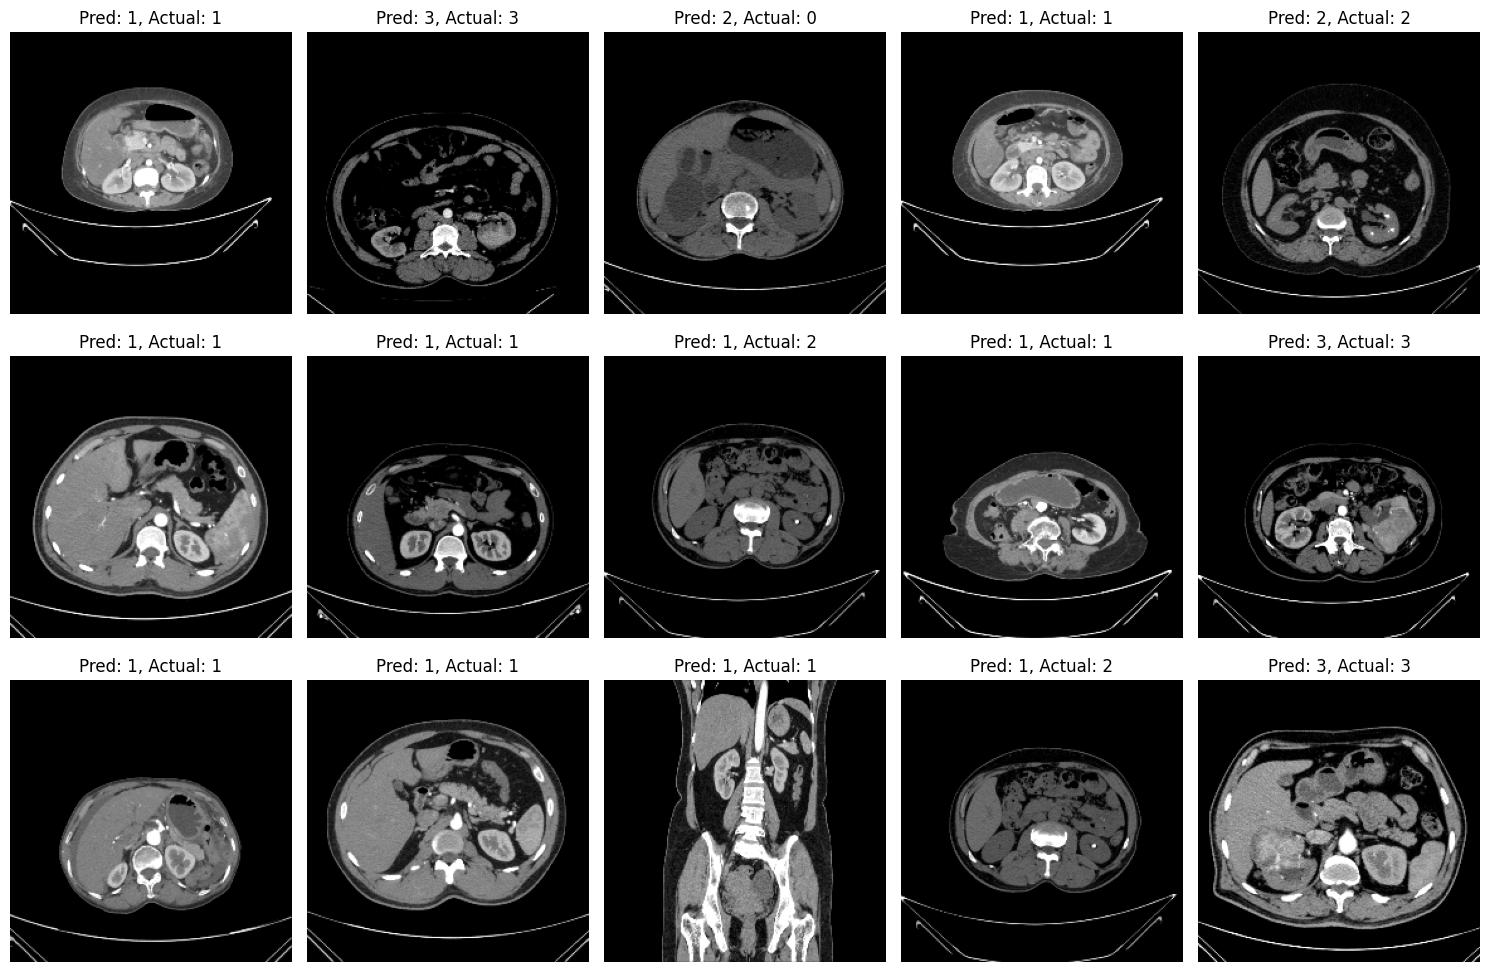

In [20]:
# Assuming x_test is your test dataset and y_test contains actual labels
num_images = 15  # Number of images to predict
predictions = []

plt.figure(figsize=(15, 10))

for i in range(num_images):
    # Prepare single image for prediction
    single_image = x_test[i]
    single_image_rgb = np.repeat(single_image, 3, axis=-1)  # Convert grayscale to RGB
    single_image_rgb = np.expand_dims(single_image_rgb, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model2.predict(single_image_rgb)
    predictions.append(prediction[0])
    
    # Display image with prediction and actual label
    plt.subplot(int(num_images/5), 5, i + 1)
    plt.imshow(single_image, cmap='gray')
    plt.title(f"Pred: {np.argmax(prediction[0])}, Actual: {np.argmax(y_test[i])}")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [16]:
# Segment Importance Heatmap #
import numpy as np
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt

c:\Users\Manisha\anaconda3\envs\python\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [17]:
for i in range(10):
    # Prepare single image for prediction
    single_image = x_test[i]
    single_image_rgb = np.repeat(single_image, 3, axis=-1)  # Convert grayscale to RGB
    single_image_rgb = np.expand_dims(single_image_rgb, axis=0)  # Add batch dimension
    
    # Make prediction
    prediction = model2.predict(single_image_rgb)
    print(prediction)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
[[2.4880464e-33 9.9165428e-01 7.8502690e-06 8.3378889e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
[[1.4663314e-16 7.1745984e-02 7.7791894e-03 9.2047489e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
[[2.0466038e-04 7.3633105e-02 8.9681584e-01 2.9346487e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
[[3.3967657e-27 6.9542378e-01 2.5437188e-05 3.0455077e-01]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[4.0568188e-16 7.5709246e-02 9.2322856e-01 1.0621537e-03]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
[[1.1876270e-23 9.6861815e-01 1.9999135e-04 3.1181823e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[3.3671482e-11 8.2630950e-01 1.5296389e-01 2.0726696e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
[[1.3613985e-16 5.3310305e-01 4.3383315e-01 3.3063874e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
[[1.4149952e-15 8.9661318e-01 9.1416076e-02 1.1970704e-02]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[1.5769227e-18 2.7952794e-02 5.7427791e-05 9.7198975e-01]]


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


  7%|▋         | 10/150 [00:00<00:05, 23.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 13%|█▎        | 20/150 [00:00<00:05, 22.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step


 20%|██        | 30/150 [00:01<00:05, 23.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step


 27%|██▋       | 40/150 [00:01<00:04, 22.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 33%|███▎      | 50/150 [00:02<00:04, 23.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 40%|████      | 60/150 [00:02<00:03, 23.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


 47%|████▋     | 70/150 [00:03<00:03, 21.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 21.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step


 60%|██████    | 90/150 [00:03<00:02, 22.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 22.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 73%|███████▎  | 110/150 [00:04<00:01, 22.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 80%|████████  | 120/150 [00:05<00:01, 23.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


 87%|████████▋ | 130/150 [00:05<00:00, 22.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 23.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 342ms/step


100%|██████████| 150/150 [00:06<00:00, 22.83it/s]

[1, 2, 3, 0]


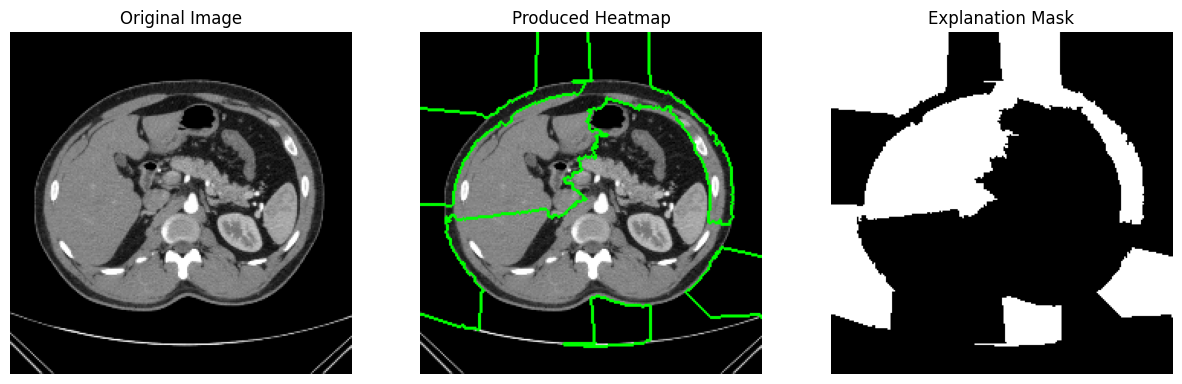

In [19]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import slic
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries

# Function for preparing image for LIME
def prepare_image_for_lime(image):
    if image.shape[-1] == 1:
        # image = cv2.resize(image, (224,224))
        # image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        image = np.repeat(image, 3, axis=-1)
    # else:
    #     image = cv2.resize(image, (224,224))
    #     image = np.array(image).reshape(224, 224, 1)  # Reshape for CNN input

    #     # image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
    #     image = np.repeat(image, 3, axis=-1)
    return image

# Define model prediction function for LIME
def model_predict_proba(image_array):
    image_array = tf.image.resize(image_array, (224, 224))  # Resize to match model input
    # image_array = np.expand_dims(image_array, axis=0)  # Add batch dimension
    return model2.predict(image_array)

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer(kernel_width=0.10, random_state=42)

# Generate heatmap and explanation with LIME
def generate_lime_heatmap_and_explanation(model, image):
    image_rgb = prepare_image_for_lime(image)
    
    explanation = explainer.explain_instance(
        image_rgb,
        model_predict_proba,
        top_labels=4,  # Focus on the top predicted label for clarity
        hide_color=1,
        distance_metric='cosine', 
        num_samples=150,
        segmentation_fn=lambda x: slic(x, n_segments=33)  # Adjusted parameters
    )
    print(explanation.top_labels)
    temp, mask = explanation.get_image_and_mask(
        label=explanation.top_labels[0],  # Get the top label instead of second one
        positive_only=True,
        hide_rest=False,
        num_features=100,  # Limit features for clarity
        min_weight=0.065
    )
    
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(image_rgb)
    plt.title("Original Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    heatmap_with_boundaries = mark_boundaries(temp, mask, color=(0, 1, 0), mode='thick')
    plt.imshow(heatmap_with_boundaries)
    plt.title("Produced Heatmap")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(mask, cmap='gray')
    plt.title("Explanation Mask")
    plt.axis("off")
    
    plt.show()
    
    return heatmap_with_boundaries, mask, explanation

# Test LIME heatmap generation with a sample image
sample_index = 11
sample_image = x_test[sample_index]
heatmap, mask, ex = generate_lime_heatmap_and_explanation(model2, sample_image)

In [20]:
import skimage.segmentation

In [21]:
im = prepare_image_for_lime(sample_image)
superpixels = skimage.segmentation.quickshift(im, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

29

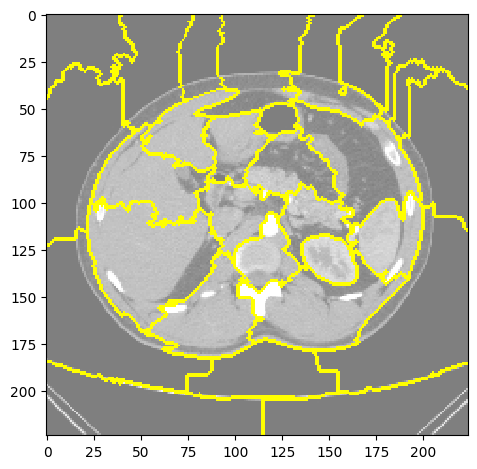

In [22]:
skimage.io.imshow(skimage.segmentation.mark_boundaries(im/2+0.5, superpixels))


In [29]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from lime import lime_image
from skimage.segmentation import slic, quickshift
from skimage.color import label2rgb
from skimage.segmentation import mark_boundaries

# Function for preparing image for LIME
def prepare_image_for_lime(image):
    if image.shape[-1] == 1:
        image = np.repeat(image, 3, axis=-1)
    return image

# Define model prediction function for LIME
def model_predict_proba(image_array):
    image_array = tf.image.resize(image_array, (224, 224))  # Resize to match model input
    return model2.predict(image_array)

# Initialize LimeImageExplainer
explainer = lime_image.LimeImageExplainer(kernel_width=0.10, random_state=42)

# Generate heatmap and explanation with LIME
def generate_lime_heatmap_and_explanation(model, image):
    image_rgb = prepare_image_for_lime(image)
    im = prepare_image_for_lime(image)
    
    # Use quickshift to find superpixels
    superpixels = quickshift(im, kernel_size=4, max_dist=200, ratio=0.2)
    
    explanation = explainer.explain_instance(
        image_rgb,
        model_predict_proba,
        top_labels=4,
        hide_color=1,
        distance_metric='cosine', 
        num_samples=150,
        segmentation_fn=lambda x: slic(x, n_segments=np.unique(superpixels).shape[0])
    )
    return explanation, image_rgb

exp =[]
for i in range(10):
    # Test LIME heatmap generation with a sample image
    # sample_index = 18
    sample_image = x_test[i]
    a,b = generate_lime_heatmap_and_explanation(model2, sample_image)
    exp.append((a,b))

  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


  7%|▋         | 10/150 [00:00<00:06, 21.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 13%|█▎        | 20/150 [00:00<00:06, 20.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 20%|██        | 30/150 [00:01<00:05, 20.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 27%|██▋       | 40/150 [00:01<00:05, 21.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 33%|███▎      | 50/150 [00:02<00:04, 22.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 40%|████      | 60/150 [00:02<00:03, 22.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step


 47%|████▋     | 70/150 [00:03<00:03, 23.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 23.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step


 60%|██████    | 90/150 [00:03<00:02, 23.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 23.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


 73%|███████▎  | 110/150 [00:04<00:01, 23.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step


 80%|████████  | 120/150 [00:05<00:01, 23.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 87%|████████▋ | 130/150 [00:05<00:00, 23.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 410ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 22.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


  7%|▋         | 10/150 [00:00<00:06, 23.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 13%|█▎        | 20/150 [00:00<00:05, 23.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step


 20%|██        | 30/150 [00:01<00:05, 23.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 27%|██▋       | 40/150 [00:01<00:04, 23.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 33%|███▎      | 50/150 [00:02<00:04, 23.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step


 40%|████      | 60/150 [00:02<00:03, 23.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 47%|████▋     | 70/150 [00:03<00:03, 22.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 351ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 23.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 60%|██████    | 90/150 [00:03<00:02, 23.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 23.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 73%|███████▎  | 110/150 [00:04<00:01, 22.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step


 80%|████████  | 120/150 [00:05<00:01, 22.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 87%|████████▋ | 130/150 [00:05<00:00, 21.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 22.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 349ms/step


  7%|▋         | 10/150 [00:00<00:06, 23.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 13%|█▎        | 20/150 [00:00<00:05, 22.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 20%|██        | 30/150 [00:01<00:05, 22.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 27%|██▋       | 40/150 [00:01<00:04, 22.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 33%|███▎      | 50/150 [00:02<00:04, 22.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 40%|████      | 60/150 [00:02<00:04, 22.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 47%|████▋     | 70/150 [00:03<00:03, 22.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 22.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step


 60%|██████    | 90/150 [00:03<00:02, 22.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 22.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 73%|███████▎  | 110/150 [00:04<00:01, 21.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 80%|████████  | 120/150 [00:05<00:01, 22.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 87%|████████▋ | 130/150 [00:05<00:00, 22.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 22.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


  7%|▋         | 10/150 [00:00<00:06, 22.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 13%|█▎        | 20/150 [00:00<00:05, 22.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


 20%|██        | 30/150 [00:01<00:05, 22.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 27%|██▋       | 40/150 [00:01<00:04, 22.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 33%|███▎      | 50/150 [00:02<00:04, 22.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 40%|████      | 60/150 [00:02<00:03, 22.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 47%|████▋     | 70/150 [00:03<00:03, 22.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 22.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 60%|██████    | 90/150 [00:03<00:02, 22.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 21.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 73%|███████▎  | 110/150 [00:04<00:01, 21.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 372ms/step


 80%|████████  | 120/150 [00:05<00:01, 21.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 87%|████████▋ | 130/150 [00:05<00:00, 21.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 21.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step


  7%|▋         | 10/150 [00:00<00:06, 23.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 13%|█▎        | 20/150 [00:00<00:05, 22.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 20%|██        | 30/150 [00:01<00:05, 22.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 27%|██▋       | 40/150 [00:01<00:04, 22.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 33%|███▎      | 50/150 [00:02<00:04, 21.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step


 40%|████      | 60/150 [00:02<00:04, 21.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 47%|████▋     | 70/150 [00:03<00:03, 21.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 21.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 60%|██████    | 90/150 [00:04<00:02, 21.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 21.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 73%|███████▎  | 110/150 [00:05<00:01, 20.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


 80%|████████  | 120/150 [00:05<00:01, 19.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 87%|████████▋ | 130/150 [00:06<00:00, 20.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 20.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


  7%|▋         | 10/150 [00:00<00:06, 20.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 13%|█▎        | 20/150 [00:00<00:05, 21.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 20%|██        | 30/150 [00:01<00:05, 22.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 347ms/step


 27%|██▋       | 40/150 [00:01<00:04, 22.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 33%|███▎      | 50/150 [00:02<00:04, 22.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step


 40%|████      | 60/150 [00:02<00:03, 23.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step


 47%|████▋     | 70/150 [00:03<00:03, 23.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 22.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


 60%|██████    | 90/150 [00:03<00:02, 22.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 22.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 362ms/step


 73%|███████▎  | 110/150 [00:04<00:01, 22.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 80%|████████  | 120/150 [00:05<00:01, 22.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step


 87%|████████▋ | 130/150 [00:05<00:00, 22.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 21.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


  7%|▋         | 10/150 [00:00<00:06, 23.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step


 13%|█▎        | 20/150 [00:00<00:05, 22.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 20%|██        | 30/150 [00:01<00:05, 22.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


 27%|██▋       | 40/150 [00:01<00:04, 22.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 370ms/step


 33%|███▎      | 50/150 [00:02<00:04, 22.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 40%|████      | 60/150 [00:02<00:04, 22.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 47%|████▋     | 70/150 [00:03<00:03, 21.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 20.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 60%|██████    | 90/150 [00:04<00:02, 20.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 21.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 387ms/step


 73%|███████▎  | 110/150 [00:05<00:01, 20.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 80%|████████  | 120/150 [00:05<00:01, 21.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


 87%|████████▋ | 130/150 [00:06<00:00, 20.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 20.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


  7%|▋         | 10/150 [00:00<00:06, 22.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 13%|█▎        | 20/150 [00:00<00:06, 21.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


 20%|██        | 30/150 [00:01<00:05, 20.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 543ms/step


 27%|██▋       | 40/150 [00:02<00:06, 17.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 33%|███▎      | 50/150 [00:02<00:05, 19.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step


 40%|████      | 60/150 [00:03<00:04, 18.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step


 47%|████▋     | 70/150 [00:03<00:04, 19.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


 53%|█████▎    | 80/150 [00:04<00:03, 19.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step


 60%|██████    | 90/150 [00:04<00:03, 19.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step


 67%|██████▋   | 100/150 [00:05<00:02, 19.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


 73%|███████▎  | 110/150 [00:05<00:02, 19.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 80%|████████  | 120/150 [00:06<00:01, 20.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step


 87%|████████▋ | 130/150 [00:06<00:00, 20.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step


 93%|█████████▎| 140/150 [00:07<00:00, 20.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step


  7%|▋         | 10/150 [00:00<00:06, 21.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 13%|█▎        | 20/150 [00:00<00:06, 21.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 385ms/step


 20%|██        | 30/150 [00:01<00:05, 20.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 421ms/step


 27%|██▋       | 40/150 [00:01<00:05, 19.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step


 33%|███▎      | 50/150 [00:02<00:05, 19.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step


 40%|████      | 60/150 [00:02<00:04, 20.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step


 47%|████▋     | 70/150 [00:03<00:03, 20.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 20.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 60%|██████    | 90/150 [00:04<00:02, 20.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 20.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step


 73%|███████▎  | 110/150 [00:05<00:01, 20.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 80%|████████  | 120/150 [00:06<00:01, 19.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 87%|████████▋ | 130/150 [00:06<00:01, 19.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


 93%|█████████▎| 140/150 [00:07<00:00, 19.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 407ms/step


  0%|          | 0/150 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step


  7%|▋         | 10/150 [00:00<00:06, 23.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 13%|█▎        | 20/150 [00:00<00:05, 22.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 20%|██        | 30/150 [00:01<00:05, 21.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 27%|██▋       | 40/150 [00:01<00:05, 21.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step


 33%|███▎      | 50/150 [00:02<00:04, 21.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 40%|████      | 60/150 [00:02<00:04, 20.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step


 47%|████▋     | 70/150 [00:03<00:03, 20.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step


 53%|█████▎    | 80/150 [00:03<00:03, 19.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step


 60%|██████    | 90/150 [00:04<00:03, 19.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


 67%|██████▋   | 100/150 [00:04<00:02, 20.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step


 73%|███████▎  | 110/150 [00:05<00:01, 20.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step


 80%|████████  | 120/150 [00:05<00:01, 20.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step


 87%|████████▋ | 130/150 [00:06<00:00, 20.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 382ms/step


 93%|█████████▎| 140/150 [00:06<00:00, 20.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step


100%|██████████| 150/150 [00:07<00:00, 20.50it/s]


C:\Users\Manisha\AppData\Local\Temp\ipykernel_24084\2909145102.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("hsv", num_colors)  # Use HSV colormap for vibrant colors


Local explanations for label 0:
[(12, -3.0664133458016875e-06), (11, -2.8675217585943944e-06), (20, -2.595175044932442e-06), (8, 2.4986382500309634e-06), (7, -2.380091538897097e-06), (30, -2.3590434544303614e-06), (13, -2.2283048067469617e-06), (19, -2.0779700449679147e-06), (17, -2.0636806937836503e-06), (21, -1.9903164614917917e-06), (18, -1.9591441612310346e-06), (4, 1.9377158376238286e-06), (27, 1.925613356439395e-06), (25, 1.7445843235839138e-06), (24, 1.7382042708556392e-06), (22, 1.7339371279505608e-06), (2, 1.679579430559663e-06), (0, -1.6351025367125458e-06), (28, 1.5914377271375902e-06), (9, 1.409689414082575e-06), (10, -1.3757494163428308e-06), (23, 1.3745430347608285e-06), (1, 1.3730393285650554e-06), (6, -1.338211056350186e-06), (14, 1.2640271864961913e-06), (16, -1.245126267873498e-06), (3, 1.2303720292028027e-06), (29, -1.046443937000732e-06), (26, -1.0313971846504429e-06), (15, -6.548580178434886e-07), (5, -6.834992613291983e-08)]
Segment 0: Weight 0.0000, Color (1.0, 0

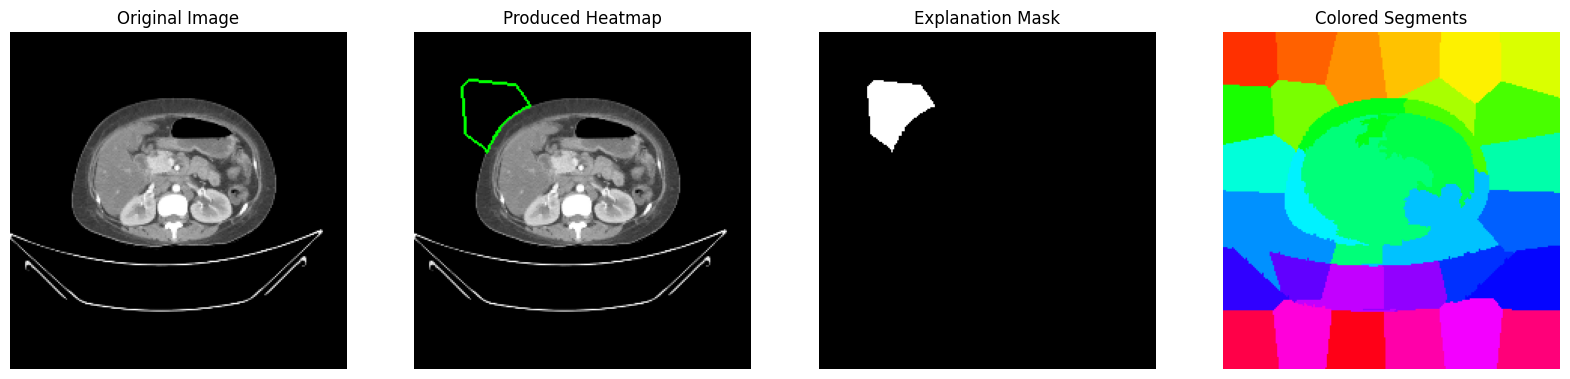

Local explanations for label 0:
[(15, -0.0018128630279645405), (6, -0.001532645837259854), (22, -0.0015038696291177283), (8, -0.0014803874216585981), (1, -0.00138307438207954), (17, -0.00133759496811568), (36, -0.0012903992800250572), (32, 0.0012290878280738276), (14, 0.0011321390862443026), (30, 0.001107044621583367), (28, -0.0010343272150302588), (13, -0.0009924505044756643), (11, 0.0009881550578859492), (18, -0.0009331145694929846), (5, 0.000917309653393819), (2, 0.0009100649079146224), (10, 0.0009057627016633748), (9, -0.0008891162081189344), (29, -0.0008817385242851764), (25, -0.0008130538855447845), (26, -0.0008113285211966133), (0, -0.0007771722514841935), (7, 0.0007525296793397798), (35, 0.0006727994618750827), (31, 0.0006066811747797076), (34, -0.0005715734117336255), (37, 0.0003761278313902724), (27, -0.0003297471807995151), (24, 0.00024661166580920897), (21, 0.00022942001064911314), (38, 0.0001666283510717418), (3, -0.00016200663507172025), (16, -0.00014240230186140317), (20

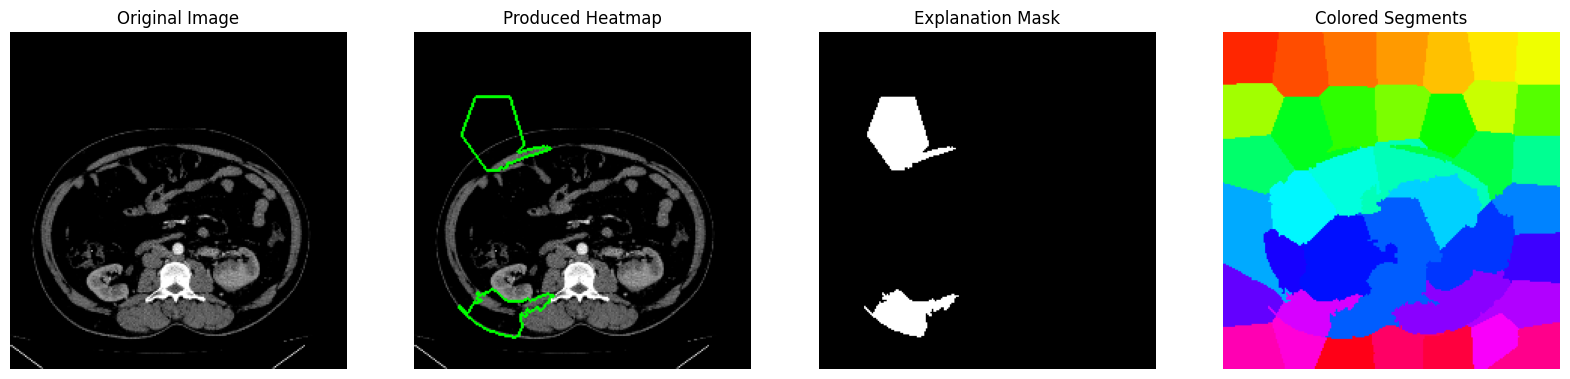

Local explanations for label 0:
[(41, -0.05863360557232934), (16, -0.05437024793842473), (27, 0.031403566919220964), (36, -0.029686182249235877), (7, 0.029005808121093785), (38, -0.02690092827985175), (3, -0.025969149912223446), (32, -0.025355650857335196), (30, 0.025336467997396216), (11, -0.025176725793136553), (26, -0.02326968275881423), (8, -0.022639093115376728), (9, 0.01931751543043631), (34, -0.016814727503678333), (17, 0.016362565909248408), (42, -0.01613001070393116), (5, -0.015186193284205271), (1, -0.014249292908673826), (22, -0.012664886944499567), (39, 0.011943534515376454), (25, -0.010793445801983555), (14, -0.010213769900952002), (20, 0.009866234656514598), (15, 0.009538884139007374), (13, 0.00923014880201506), (6, -0.008354246940426432), (40, 0.008319912239348387), (31, 0.008290970874441953), (21, 0.007622960963057335), (29, -0.007553134120621977), (35, -0.007067711736010869), (33, 0.006681090019913581), (24, -0.005375706458617462), (18, -0.004623356692032184), (28, -0.

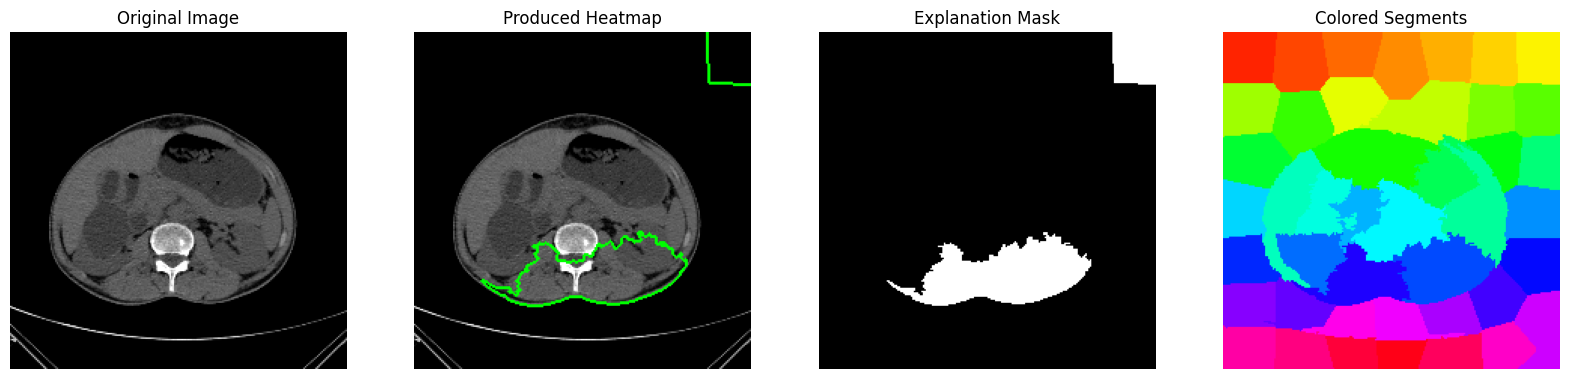

Local explanations for label 0:
[(14, -0.00026866845159134403), (22, -0.00025893550755299655), (18, 0.0002568936711381241), (25, -0.000255074985463371), (9, -0.00023582197530335294), (28, 0.00018608195236377372), (3, -0.00017851565023871622), (1, 0.0001592142494846186), (2, -0.00014972305689765886), (0, 0.0001378845984641487), (4, -0.000132884609890344), (16, 0.00011998414229678019), (17, 0.00011053658389452309), (5, -0.00010778260135058157), (15, -9.87428779121818e-05), (6, 8.911482177205015e-05), (8, -8.512608365267826e-05), (20, 7.584322108180042e-05), (10, 7.290670926780125e-05), (19, -7.2717908315088e-05), (24, -6.685734669977853e-05), (26, -6.143871140590043e-05), (11, -6.006181917483303e-05), (27, 4.13432176431e-05), (12, -4.110452562696582e-05), (7, 3.554554869241283e-05), (13, -2.032144008797925e-05), (21, -6.424021162953725e-06), (23, 4.909967695731602e-08)]
Segment 0: Weight 0.0001, Color (1.0, 0.0, 0.0)
Segment 1: Weight 0.0002, Color (1.0, 0.20366399676744504, 0.0)
Segment

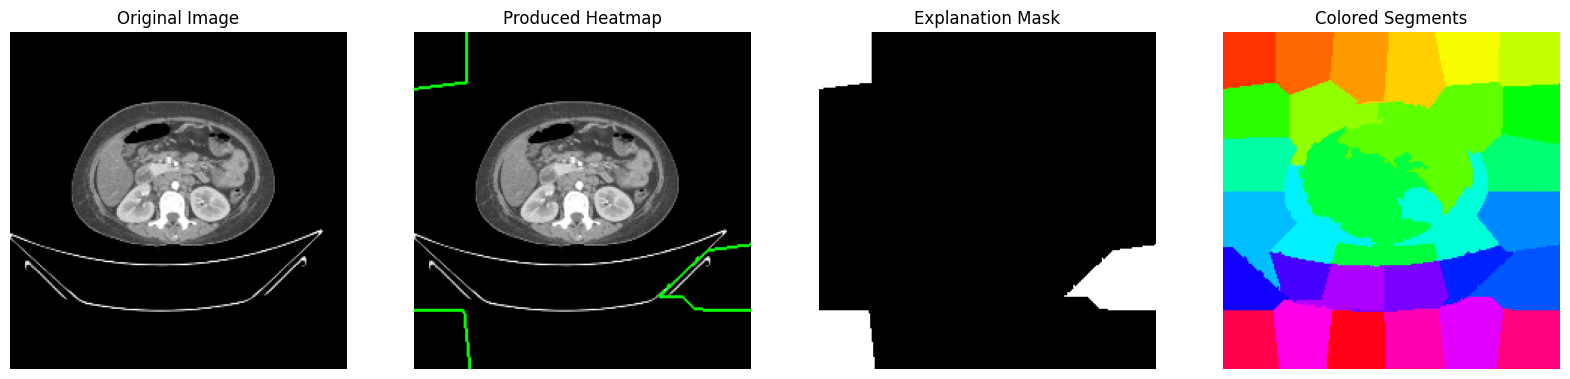

Local explanations for label 0:
[(10, -0.0030048373042683256), (6, -0.002609871819527181), (14, -0.002525294852864883), (20, 0.0025094486031904777), (2, -0.0022231509553979757), (11, -0.0021645632753719193), (18, 0.0020392460113316225), (16, -0.002001769952147955), (17, -0.0018741795929807783), (26, 0.0018284543097750452), (15, 0.0018116149000572373), (4, -0.0017430775343029597), (12, -0.001699876844706509), (5, -0.0016974985249901071), (13, 0.001669734462288728), (3, 0.0014903638159625833), (1, 0.0013915962020059692), (24, 0.0013015706879158507), (0, 0.0010970284548961389), (21, -0.0009146890951481779), (22, 0.00072400289671297), (8, -0.0005406853819371055), (25, -0.0005075797396747918), (23, 0.0004280295064291657), (9, -0.0003788056162781221), (7, -0.0002889539320986501), (19, 0.0002046100477204468)]
Segment 0: Weight 0.0011, Color (1.0, 0.0, 0.0)
Segment 1: Weight 0.0014, Color (1.0, 0.21875021875021874, 0.0)
Segment 2: Weight 0.0022, Color (1.0, 0.4375004375004375, 0.0)
Segment 3: 

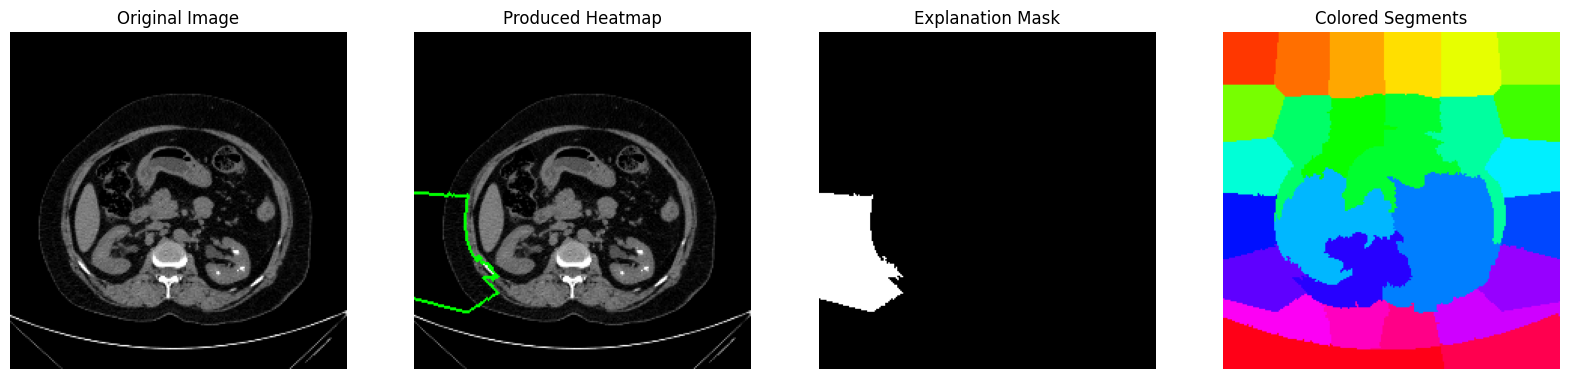

Local explanations for label 0:
[(22, -0.0269279270828286), (27, -0.024851142404771952), (17, -0.023061531056997236), (19, 0.022487605484941397), (5, 0.021538986001869403), (14, 0.021368471936939283), (4, 0.020955484048235145), (13, -0.01873477336684934), (28, 0.01803971496580741), (0, -0.016679596117143605), (2, -0.015307101820163056), (6, -0.014306955353987646), (20, -0.013938289335780658), (25, -0.013796236331393524), (15, -0.012981465475876757), (1, 0.012276382261244364), (9, 0.010990485886457969), (23, 0.009205597815439863), (11, -0.0075217111608189184), (26, -0.00723339636028445), (3, 0.006409795396338471), (7, 0.006085835959765543), (16, -0.004921149267361313), (8, 0.00455466954809123), (21, -0.004026165516044531), (24, 0.0027342491409137588), (18, -0.002436791024807922), (12, -0.002152751822668466), (10, -0.0017645502923942374)]
Segment 0: Weight 0.0167, Color (1.0, 0.0, 0.0)
Segment 1: Weight 0.0123, Color (1.0, 0.20366399676744504, 0.0)
Segment 2: Weight 0.0153, Color (1.0, 0

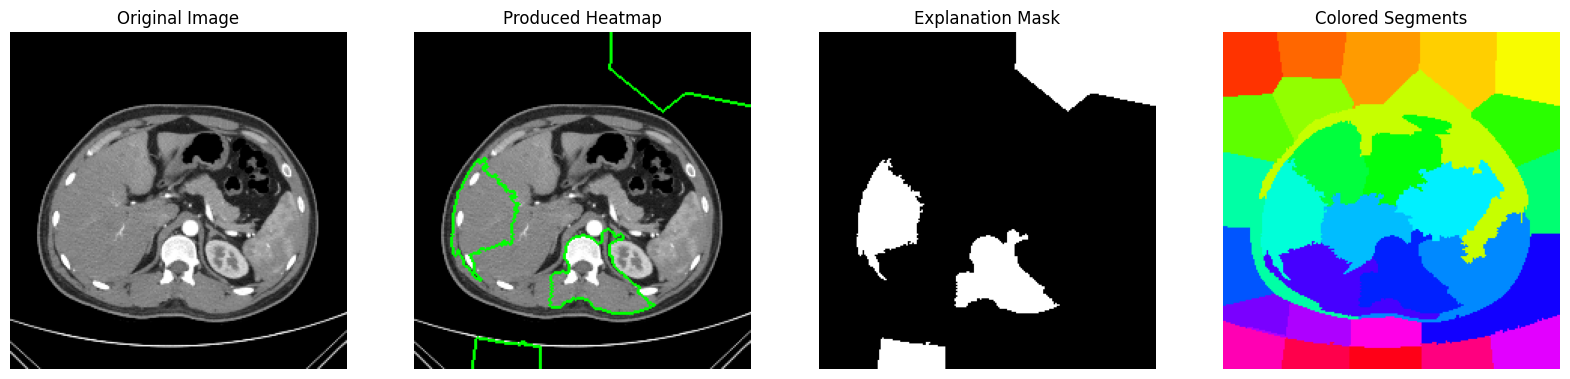

Local explanations for label 0:
[(4, -0.0002291536679039881), (14, 0.0002126070736213409), (33, 0.00019953846771548746), (39, -0.0001991422347984477), (32, -0.00019249093760759342), (13, -0.0001809338107400204), (10, -0.0001764798055783533), (40, -0.00016994968215558798), (21, -0.00016984105944340086), (27, -0.00016771174424538778), (24, -0.00016492178867509488), (25, 0.0001599721440028196), (35, 0.00015133152973140327), (38, -0.0001496243299295601), (0, 0.0001470583095577986), (11, 0.00013877677923607043), (19, 0.00013433734940729647), (30, -0.00012912428888383972), (26, 0.00012695110981613393), (23, 0.00011562725693629527), (7, 0.00011063036532044451), (6, 0.00010358982644124195), (29, -9.644466538476065e-05), (2, -9.570385139751354e-05), (34, -9.542277927795856e-05), (31, -8.939534446894098e-05), (28, -8.434449812396862e-05), (22, 8.175575481043721e-05), (37, -7.086923567305841e-05), (5, -6.776114776295472e-05), (16, 6.055691261482981e-05), (15, -6.008198738261244e-05), (17, -5.5474

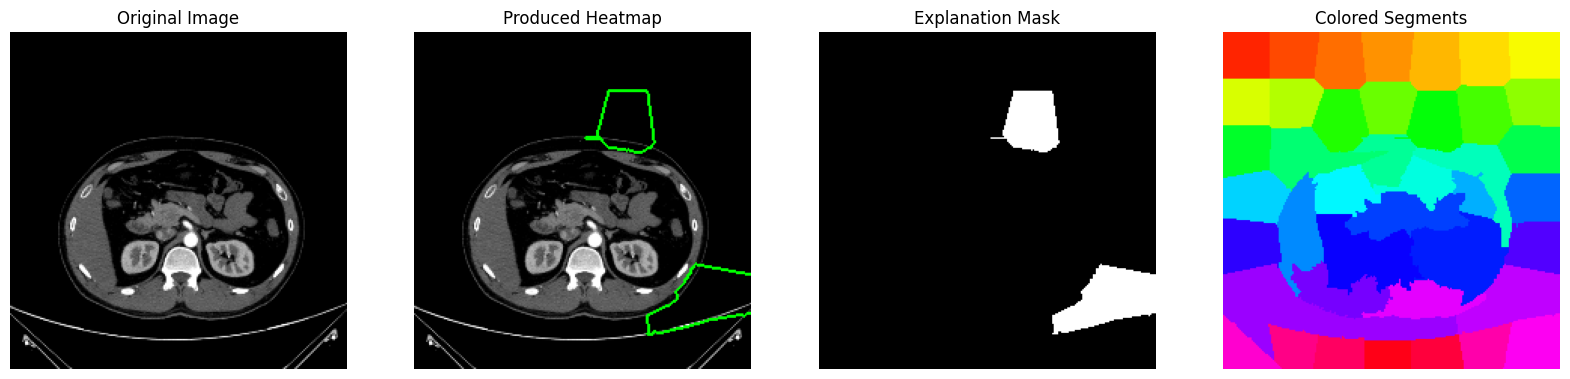

Local explanations for label 0:
[(29, -0.02759924210128642), (6, -0.026748989589386), (16, -0.02581985621875054), (26, -0.02537779464052558), (27, -0.02337753405911815), (1, -0.021672978614807218), (0, -0.019860973394298848), (7, -0.019526534231857753), (24, 0.019242250555714924), (17, -0.01920641863111734), (28, -0.017743201811135926), (21, 0.016864747888162956), (18, 0.016849594515283017), (11, 0.016007219079782833), (12, -0.015938562626863047), (19, 0.01280702066056524), (9, 0.012724066363692561), (3, 0.01223608005036952), (25, 0.011624371185616433), (22, 0.011154417068384102), (5, 0.010713446413307428), (13, 0.009869097704608984), (10, -0.008434872273434943), (2, 0.008329196602188558), (14, 0.007619306155466051), (8, 0.006839000057851716), (20, 0.00672116194137051), (30, 0.006528879006195519), (4, 0.0038243949027596293), (23, 0.0035088562729171046), (15, 0.0026631592063727414)]
Segment 0: Weight 0.0199, Color (1.0, 0.0, 0.0)
Segment 1: Weight 0.0217, Color (1.0, 0.19052438407277117

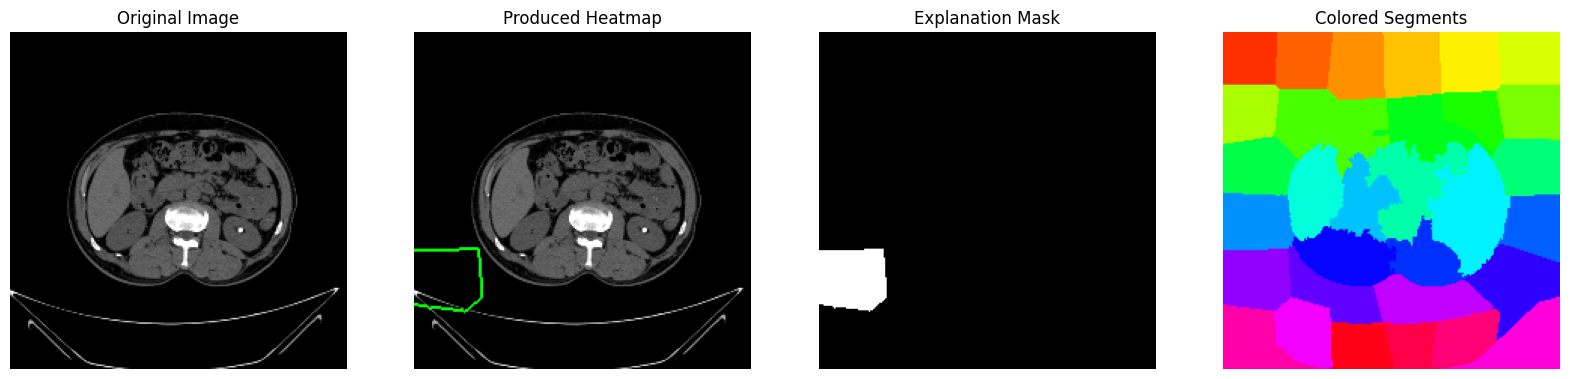

Local explanations for label 0:
[(14, -0.007904899837635981), (22, -0.007858574488700377), (26, 0.006962758452540723), (0, -0.006927295658839157), (17, 0.006566840598523172), (19, -0.006509038451665667), (35, -0.006219189225528808), (1, -0.005934757775787545), (36, 0.005272801490788743), (18, -0.0052139728306967795), (6, -0.005203146548542775), (12, 0.005161029888709787), (4, -0.005155165780267248), (10, 0.005103670658697778), (20, -0.005069927221999133), (13, 0.0050623739173904754), (3, -0.004978979326992109), (11, -0.0047584348677850346), (7, 0.004756120702146613), (8, 0.0046879634245162675), (23, -0.0044153992354551575), (25, -0.0043002127496769415), (32, -0.004258238913939347), (27, 0.004139732614335602), (29, 0.004010306307203134), (2, 0.0038701222146651933), (34, -0.0037381312084927227), (33, 0.003471380613200261), (5, -0.0033112485850401146), (15, 0.0032731572474030564), (31, 0.002940921325667927), (24, 0.0028010377103104486), (16, 0.0020667257968924034), (9, 0.00203138049898253

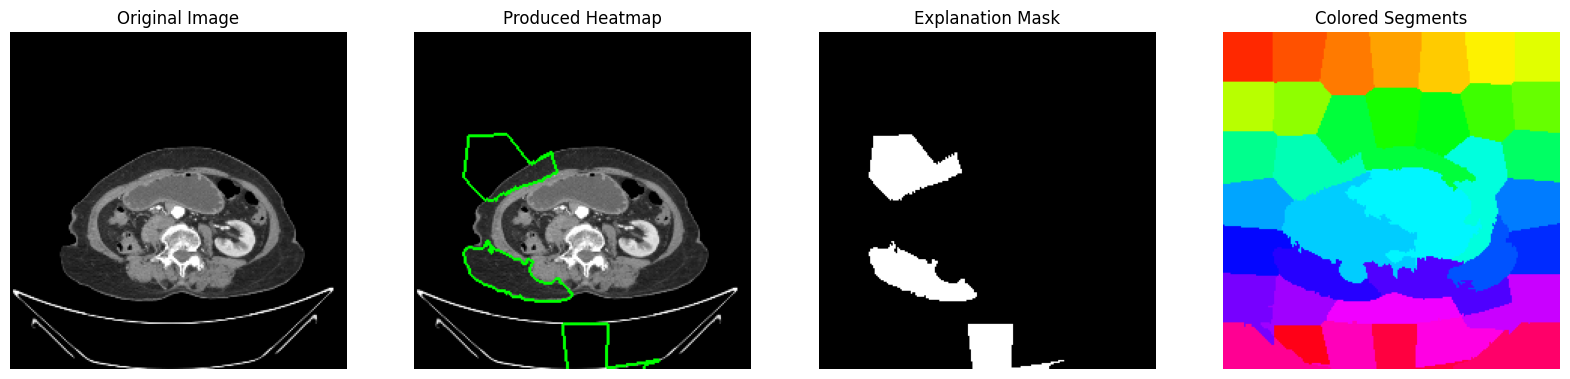

Local explanations for label 0:
[(17, -0.017173182812017393), (13, -0.011973037830793593), (2, -0.011338930450124846), (28, 0.009803356814996384), (0, 0.00968113127552449), (14, -0.008762671697690176), (34, 0.007969961364825915), (8, -0.00767399015712557), (7, 0.007391971046017361), (35, -0.007376703972727308), (31, -0.00617137620176593), (33, -0.005815618481784439), (36, 0.0057918225335298786), (10, 0.005566623748114319), (12, -0.00547791878398514), (19, -0.004892643644095562), (6, -0.004862315510328045), (5, 0.004763131741136869), (3, -0.004561951625058887), (29, -0.0038689599845836424), (21, -0.00362112191848494), (23, 0.0036200274270973016), (1, -0.0035587487268446006), (4, -0.003399912977226553), (37, -0.003215919280713972), (26, 0.0030489834042392787), (18, 0.002937302329224711), (11, 0.0027003497346261745), (16, 0.002436105455727484), (24, 0.002227218673715389), (20, -0.001978622411032574), (27, 0.0014858395866206172), (9, 0.0014110842103833615), (38, 0.001395672747545424), (25,

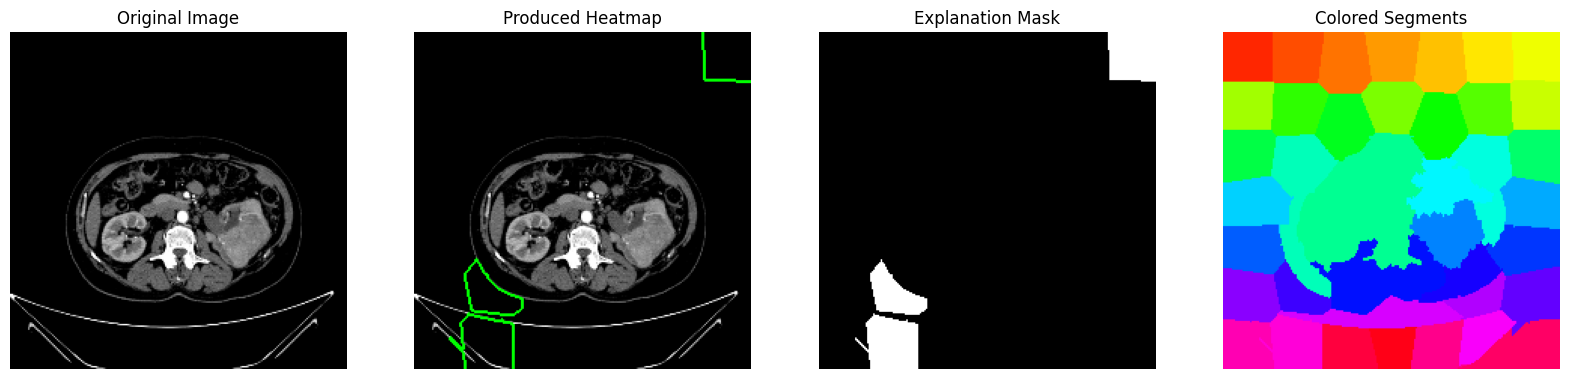

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

def generate_vibrant_colors(num_colors):
    """Generate a list of vibrant colors."""
    colors = plt.cm.get_cmap("hsv", num_colors)  # Use HSV colormap for vibrant colors
    return [colors(i)[:3] for i in range(num_colors)]  # Return RGB values

def haha(explanation, image_rgb, target_label, num_segments_to_select=10):
    # Extract segment weights for all segments
    num_segments = np.max(explanation.segments) + 1  # Total number of segments
    segment_weights = np.zeros(num_segments)  # Initialize weights array
    
    # Generate vibrant colors for each segment
    vibrant_colors = generate_vibrant_colors(num_segments)
    
    # Check if the target_label is in the explanation's top labels
    if target_label in explanation.top_labels:
        # Print local explanations for the specified label
        print(f"Local explanations for label {target_label}:")
        print(explanation.local_exp[target_label])
        
        # Accumulate weights for the specified label
        for segment_id, weight in explanation.local_exp[target_label]:
            segment_weights[segment_id] += np.abs(weight)  # Use absolute weight to accumulate
        
        # Print weights and associated colors for all segments
        for segment_id in range(num_segments):
            color_name = vibrant_colors[segment_id]
            print(f'Segment {segment_id}: Weight {segment_weights[segment_id]:.4f}, Color {color_name}')
        
        # Determine dynamic max_weight based on the desired number of segments
        sorted_weights = np.sort(segment_weights)
        if num_segments_to_select > len(sorted_weights):
            dynamic_max_weight = 0  # If we want more segments than available, set to zero
        else:
            dynamic_max_weight = sorted_weights[-num_segments_to_select]  # Get the weight at the position
        
        print(f"Dynamic max_weight threshold: {dynamic_max_weight:.4f}")
        
        temp, mask = explanation.get_image_and_mask(
            label=target_label,
            positive_only=True,
            hide_rest=False,
            num_features=100,
            min_weight=dynamic_max_weight  # Use dynamic max_weight here
        )
        
        plt.figure(figsize=(20, 10))
        
        plt.subplot(1, 4, 1)
        plt.imshow(image_rgb)
        plt.title("Original Image")
        plt.axis("off")

        plt.subplot(1, 4, 2)
        heatmap_with_boundaries = mark_boundaries(temp, mask, color=(0, 1, 0), mode='thick')
        plt.imshow(heatmap_with_boundaries)
        plt.title("Produced Heatmap")
        plt.axis("off")

        plt.subplot(1, 4, 3)
        plt.imshow(mask, cmap='gray')
        plt.title("Explanation Mask")
        plt.axis("off")

        # Plot all segments with distinct colors
        segmented_image = np.zeros_like(image_rgb)  # Initialize segmented image with zeros
        
        for segment_id in range(num_segments):
            mask_segment = (explanation.segments == segment_id)  # Create mask for current segment
            segmented_image[mask_segment] = vibrant_colors[segment_id][:3]  # Assign color
            
        plt.subplot(1, 4, 4)
        plt.imshow(segmented_image)
        plt.title("Colored Segments")
        plt.axis("off")
        
        plt.show()
        
    else:
        print(f"Label {target_label} not found in top labels.")

    return segment_weights

# Example usage
# Specify how many segments you want to select based on their weights
for a,b in exp:
    num_segments_to_select = 10  # Adjust this value as needed
    haha(a, b, 0, num_segments_to_select)